## Prep: Test Inference locally

Before we try to load models into Torch Serve, I'm going to download two different HuggingFace models and make sure I can do inference in a notebook.

### GPT-2

GPT-2 looks archaic compared to GPT-3

In [53]:
from transformers import pipeline
pipe = pipeline(task="text-generation", model="distilgpt2")

In [55]:
preds = pipe(["How do you use Torch Serve for model inference?", 
              "The quick brown fox jumps over the lazy"])
preds

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[[{'generated_text': 'How do you use Torch Serve for model inference? Or just use Http to help. Or as a framework, where the actual code runs as expected, like something like JRuby on top of the project? Or maybe you use some way to get'}],
 [{'generated_text': 'The quick brown fox jumps over the lazy wolf, then hops over the hoot and follows him.'}]]

### Diffusion

This definitely requires a GPU

In [51]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

repo_id = "stabilityai/stable-diffusion-2"
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda:0")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

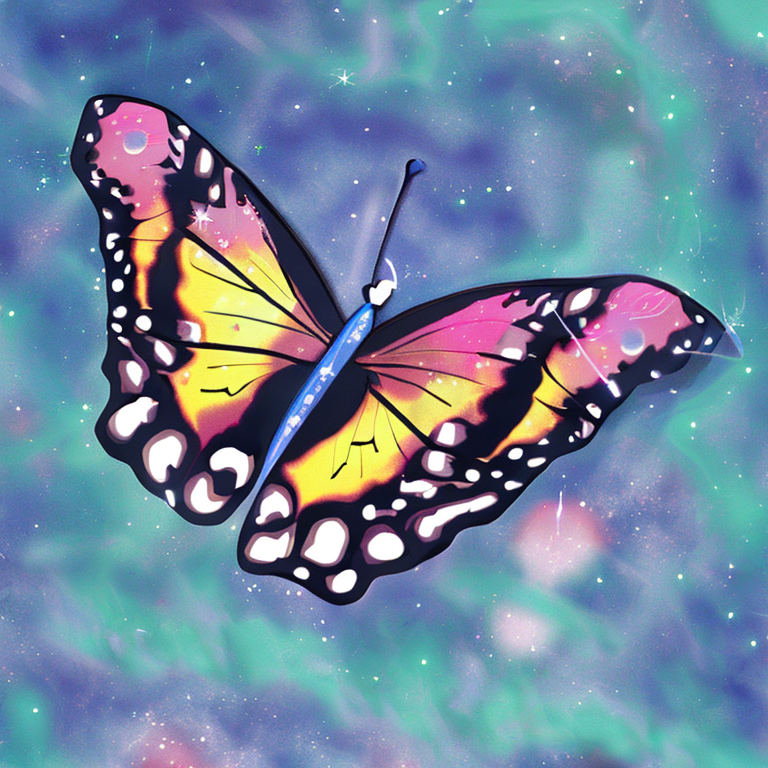

In [52]:
prompt = "A Butterly in space"
image = pipe(prompt, num_inference_steps=25)
img = image.images[0]
img

You can convert PIL to JSON serializable structures [like this](https://stackoverflow.com/a/57433803):

In [47]:
import numpy as np
img_as_list = np.array(img).tolist()

# Define a custom handler

You have to read the source code of [BaseHandler](https://github.com/pytorch/serve/blob/master/ts/torch_handler/base_handler.py) to understand what is happening.  [This blog post](https://medium.com/analytics-vidhya/deploy-huggingface-s-bert-to-production-with-pytorch-serve-27b068026d18) is helpful.  This is [an example](https://github.com/pytorch/serve/blob/master/examples/diffusers/stable_diffusion_handler.py#L24) of doing diffusion in Torch Serve.

Important methods in [BaseHandler](https://github.com/pytorch/serve/blob/master/ts/torch_handler/base_handler.py):

- **`self.handle`**: this shows you the rough lifecycle of `BaseHandler`: `initialize` -> `handle` -> `preprocess` -> `inference` -> `postprocess`
    - `initialize` isn't explicitly called in the handler, so it must be called elsewhere.  I could not find this called anywhere in the code base, so perhaps its called in Java somehow (the thing that drives the server).
- **`preprocess`**: by default this will convert data to a Torch tensor.  For the examples we are working with we don't want this, because we are using `pipeline`.
- **`self.initialize`** is where you load and instantiate the model, the name of the property that has the model is not important as long as you use it consistently across the other methods.
- **`self.inference`**: The output of `self.preprocess` is passed to `self.inference`, which then returns predictions.  Somewhere along the line before `self.inference` is called, `self.initialize` is called.  It seems important to set the `self.initialized` property to `True` in `self.initialize` (see examples)
- **`self.postprocess`**: The output of `self.inference` is passed to `self.postprocess`.  By default, this calls the `.tolist()` method on whatever object is returned from `self.inference`. 

There is also a `context` and `manifest` properties which contain values that you might supply through a config or as CLI commands (like the model's directory).  It's not clear what is contained in these variables, and the only way is to use logging statements to find out. Another way to try to get clues is to look at the [examples](https://github.com/pytorch/serve/tree/master/examples).  

:::{.callout-warning}
There is Java code that drives this python code, so unfortunately an interactive debugger does not work to figure out what is happening.  Your only way to introspect things is through logging statements.

The python code eventually leads to a dead end where you have to start reading Java code, so just looking at the code doesn't provide all the answers (but reading `BaseHandler` is still helpful).

:::

:::{.callout-tip}

#### Use environment variables instead of `context`

I was talking to a trusted source about `context` and `manifest` and he says that people often use environment variables instead of relying on `context`.  When you override `BaseHandler` and use your own environment variables, TorchServe isn't doing so much aside from auto batching and worker management.  We agreed that aside from these two features, there is little difference between using Torch Serve and FastAPI.

(I am not going to do this in this example)

:::


## GPT Handler

In [61]:
%%writefile gpt_handler.py
#gpt_handler.py
import logging
import torch
from transformers import pipeline
from ts.torch_handler.base_handler import BaseHandler

logger = logging.getLogger(__name__)
logger.info("Starting GPT Handler")

class GptHandler(BaseHandler):
    def __init__(self):
        self.initialized = False
        
    def initialize(self, ctx):
        self.manifest = ctx.manifest
        properties = ctx.system_properties
        
        self.device = torch.device(
            "cuda:" + str(properties.get("gpu_id"))
            if torch.cuda.is_available() and properties.get("gpu_id") is not None
            else "cpu"
        )
        
        # you might normaly get the model from disk, but we don't have to in this case.
        self.pipe = pipeline(task="text-generation", model="distilgpt2")
        self.initialized = True
        
    def preprocess(self, data): 
        text = data[0].get("data")
        if text is None:
            text = data[0].get("body")
        logging.info(f'Here is the text: {text}')
        sentences = text.decode('utf-8')
        return sentences
    
    def inference(self, data): return self.pipe(data)
    
    def postprocess(self, data): return data

Overwriting gpt_handler.py


## Diffusion Handler

In [62]:
%%writefile diffusion_handler.py
#diffusion_handler.py
import logging
import torch
import numpy as np
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from ts.torch_handler.base_handler import BaseHandler

logger = logging.getLogger(__name__)
logger.info("Starting Diffusion Handler")

class DiffusionHandler(BaseHandler):
    def __init__(self):
        self.initialized = False
        
    def initialize(self, ctx):
        self.manifest = ctx.manifest
        properties = ctx.system_properties
        
        self.device = torch.device(
            "cuda:" + str(properties.get("gpu_id"))
            if torch.cuda.is_available() and properties.get("gpu_id") is not None
            else "cpu"
        )
        
        repo_id = "stabilityai/stable-diffusion-2"
        self.pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
        self.pipe = self.pipe.to(self.device)
        self.initialized = True
        
    def preprocess(self, data): 
        text = data[0].get("data")
        if text is None:
            text = data[0].get("body")
        prompt = text.decode('utf-8')
        return prompt
    
    def inference(self, data): 
        image = self.pipe(data, num_inference_steps=25)
        img = image.images[0]
        return np.array(img)
    
    def postprocess(self, data): 
        return [data.tolist()]

Overwriting diffusion_handler.py


# Package The Artifacts

## Create the model archive

In [3]:
!mkdir -p model_store

! torch-model-archiver \
--export-path model_store \
--model-name "gpt" --version 1.0 \
--handler "./gpt_handler.py" \
--force

! torch-model-archiver \
--export-path model_store \
--model-name "diffusion" --version 1.0 \
--handler "./diffusion_handler.py" \
--force

WARNING - Overwriting model_store/gpt.mar ...
WARNING - Overwriting model_store/diffusion.mar ...


## Set `config.properties`

The diffusion response is bigger than the allowable default so we must pass a config.  An example is [here](https://github.com/pytorch/serve/blob/master/examples/diffusers/config.properties).  I don't know why I have to set the different ports like this, since these are the defaults (If I do not set these, things do not work properly).

In [54]:
%%writefile config/config.properties
inference_address=http://0.0.0.0:8080
management_address=http://0.0.0.0:8081
metrics_address=http://0.0.0.0:8082
load_models=all
max_response_size=655350000

Overwriting config/config.properties


## Create a Dockerfile

We can get ideas from [their Dockerfile](https://github.com/pytorch/serve/blob/master/docker/Dockerfile)

In [51]:
%%writefile Dockerfile.gpt

FROM pytorch/torchserve:latest-gpu
RUN python -m pip install transformers diffusers

ENTRYPOINT ["/usr/local/bin/dockerd-entrypoint.sh"]
CMD ["serve"]

Overwriting Dockerfile.gpt


Build the Dockerfile

In [21]:
! docker build -f Dockerfile.gpt . -t pytorch/torchserve:gpu-hf;

Sending build context to Docker daemon  334.6MB
Step 1/4 : FROM pytorch/torchserve:latest-gpu
 ---> 046086392ab2
Step 2/4 : RUN python -m pip install transformers diffusers
 ---> Using cache
 ---> 13135ca5603f
Step 3/4 : ENTRYPOINT ["/usr/local/bin/dockerd-entrypoint.sh"]
 ---> Using cache
 ---> 6910f9182230
Step 4/4 : CMD ["serve"]
 ---> Using cache
 ---> bbed6fd312c2
Successfully built bbed6fd312c2
Successfully tagged pytorch/torchserve:gpu-hf


# Start torch serve

We don't need any arguments since the BaseHandler pulls the model from the Hub, etc.

```bash
docker run --rm -it --gpus '"device=0"' \
    -p 8080:8080 \
    -p 8081:8081 \
    -p 8082:8082 \
    -p 7070:7070 \
    -p 7071:7071 \
    -v /home/hamel/hamel/notes/serving/torchserve/model_store/:/home/model-server/model_store/ \
    -v /home/hamel/hamel/notes/serving/torchserve/config/:/home/model-server/custom_config/ \
    pytorch/torchserve:gpu-hf \
    torchserve \
    --model-store /home/model-server/model_store \
    --models gpt=gpt.mar diffusion=diffusion.mar \
    --ts-config /home/model-server/custom_config/config.properties
```

# Use the REST API

## [List Models](https://pytorch.org/serve/management_api.html#list-models)

In [56]:
!curl http://127.0.0.1:8081/models

{
  "models": [
    {
      "modelName": "diffusion",
      "modelUrl": "diffusion.mar"
    },
    {
      "modelName": "gpt",
      "modelUrl": "gpt.mar"
    }
  ]
}


## Make Predictions

### GPT

With curl

In [55]:
! echo "The quick brown fox jumps over the lazy" > gpt.txt
! cat gpt.txt

The quick brown fox jumps over the lazy


In [57]:
!curl http://127.0.0.1:8080/predictions/gpt -T gpt.txt

{
  "generated_text": "The quick brown fox jumps over the lazy\nI do find some funny gifs to do.\nI used to have cats but I never find one\nI used to have dogs. But I couldn't really find a cute dog but now I enjoy"
}

With requests

In [58]:
import requests
resp = requests.post('http://127.0.0.1:8080/predictions/gpt',
                     data={'data': "The quick brown fox jumps over the lazy"})
resp.text

'{\n  "generated_text": "The quick brown fox jumps over the lazy blonde to win, the latter has to wait for the rest to come on, and she also needs a hug and a hug. The adorable feline can barely contain itself, but the kitten is quite responsive,"\n}'

### Diffusion

In [59]:
import requests
import json
from PIL import Image

resp = requests.post('http://127.0.0.1:8080/predictions/diffusion',
                     data={'data': "A butterfly in space with glasses."})

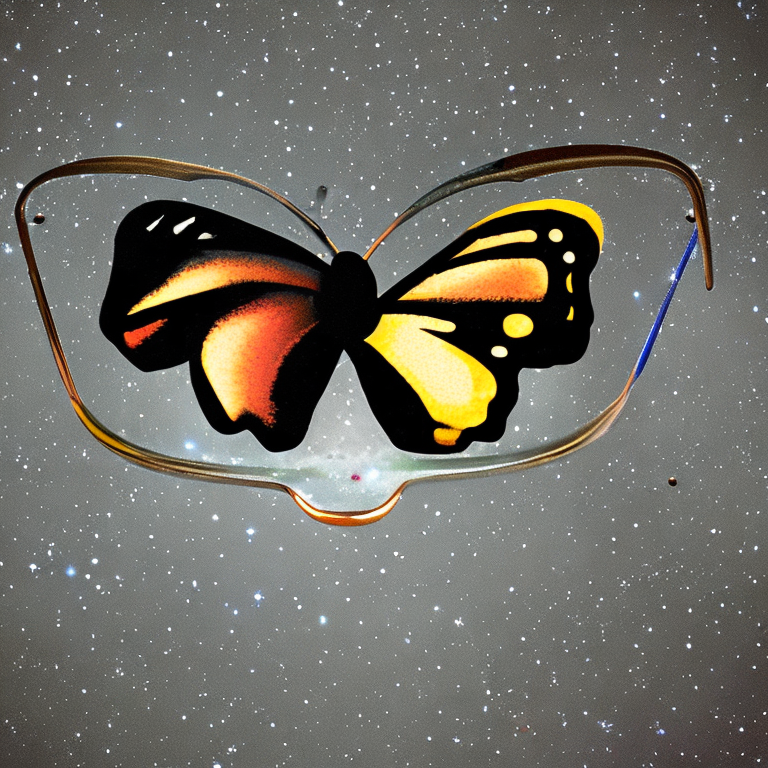

In [60]:
dimg = np.array(json.loads(resp.text), dtype='uint8')
Image.fromarray(dimg)